# Logistic Regression versus Bayes Classifier

### We Load the breast cancer dataset, import LogisticRegression, and copy the code from Activity 3.3. for the Bayes classifier (BC). For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared). Perform a training/test split (with train size equal to 0.8) and report which of the models performs best in terms of train and test performance.

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, zero_one_loss
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def sigmoid(a):
    return 1/(1+np.exp(-a))

# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [2]:
class SGDRegularisedLogisticRegressionClassifier:
    """
    Logistic Regression using Stochastic Gradient Descent with L2 Regularization.

    Parameters:
    - alpha: Regularization parameter (L2 penalty).
    - eta: Learning rate.
    - batch_size: Size of the mini-batch for stochastic gradient descent.
    - tau_max: Maximum number of iterations.
    - epsilon: Convergence threshold.
    - random_state: Seed for random number generator (used in SGD).
    """

    def __init__(self, alpha=0.1, batch_size=10, eta=0.001, tau_max=10000, epsilon=0.00001, random_state=None):
        self.alpha = alpha  # Regularization strength (L2 penalty term coefficient).
        self.eta = eta  # Learning rate for gradient descent updates.
        self.tau_max = tau_max  # Maximum number of iterations for the gradient descent.
        self.epsilon = epsilon  # Convergence threshold; stops if change in weights is below this value.
        self.random_state = random_state  # Seed for random number generator for reproducibility.
        self.batch_size = batch_size  # Size of mini-batch for stochastic gradient descent (SGD).

    def fit(self, x, y):
        """
        Fit the Logistic Regression model using Stochastic Gradient Descent (SGD).

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).
        - y: Target vector (numpy array), shape (n_samples,).
        """
        RNG = np.random.default_rng(self.random_state)  # Initialize random number generator with the given seed.
        n, p = x.shape  # Get the number of samples (n) and number of features (p) from input data 'x'.
        self.w_ = np.zeros(shape=(self.tau_max + 1, p))  # Initialize weights to zero for all features and iterations.
        
        # Perform gradient descent iterations up to the maximum number specified (tau_max).
        for tau in range(1, self.tau_max + 1):
            w_old = self.w_[tau-1]  # Store the weights from the previous iteration.
            
            # Randomly select a mini-batch of indices for SGD.
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            x_batch = x[idx]  # Select the features for the mini-batch.
            y_batch = y[idx]  # Select the target values for the mini-batch.
            
            # Compute the gradient of the cost function with L2 regularization.
            grad = x_batch.T.dot(sigmoid(x_batch.dot(w_old)) - y_batch) + self.alpha * w_old
            
            # Update weights using the computed gradient and learning rate.
            self.w_[tau] = w_old - self.eta * grad
            
            # Check for convergence: if the change in weights is less than epsilon, stop the iteration.
            if np.linalg.norm(self.w_[tau] - w_old) < self.epsilon:
                break
        
        # Final coefficients are the weights from the last iteration.
        self.coef_ = self.w_[tau]
        # Trim the weight matrix to remove unused rows.
        self.w_ = self.w_[:tau + 1]
        return self

    def decision_function(self, x):
        """
        Compute the decision function for logistic regression.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).

        Returns:
        - Linear combination of input features and learned weights (numpy array), shape (n_samples,).
        """
        return x.dot(self.coef_)  # Return the dot product of input features and weights.

    def predict(self, x):
        """
        Predict binary class labels (0 or 1) using the decision function.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).

        Returns:
        - Predicted class labels (numpy array), shape (n_samples,).
        """
        # Apply the decision function and threshold at 0 to assign class labels.
        return (self.decision_function(x) > 0).astype(int)

    def predict_proba(self, x):
        """
        Predict class probabilities for each sample.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).

        Returns:
        - Predicted class probabilities (numpy array), shape (n_samples, 2).
        """
        p1 = sigmoid(self.decision_function(x))  # Probability of the positive class.
        # Return probabilities for both classes as a 2D array.
        return np.column_stack((1 - p1, p1))


In [3]:
class BayesianClassifier:
    """
    Bayesian Classifier for Multiclass Classification.

    Parameters:
    - shared_cov: Boolean flag to use shared covariance matrix across all classes.
    - cond_ind: Boolean flag to assume conditional independence (Naive Bayes variant).
    """

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov = shared_cov  # Determines if the covariance matrix is shared among all classes.
        self.cond_ind = cond_ind  # Determines if conditional independence is assumed (Naive Bayes assumption).

    def fit(self, x, y):
        """
        Fit the Bayesian Classifier model.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).
        - y: Target vector (numpy array), shape (n_samples,).

        Returns:
        - self: Fitted model.
        """
        # Identify unique classes and their respective counts in the target vector.
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_, self.p_ = x.shape  # Store the number of samples (n) and number of features (p).
        self.k_ = len(self.classes_)  # Number of unique classes.
        
        # Initialize conditional means and covariances for each class.
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        # Compute prior probabilities for each class.
        self.class_priors_ = class_counts / len(y)
        
        # Compute conditional means and covariances for each class.
        for c in range(self.k_):
            c_rows = y == c  # Boolean array for selecting samples belonging to class 'c'.
            # Calculate mean of features for the current class.
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            
            # If conditional independence is assumed, use diagonal covariance matrix.
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                # Otherwise, use full covariance matrix.
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        # If shared covariance matrix is specified, compute it and use it for all classes.
        if self.shared_cov:
            # Compute weighted sum of covariance matrices based on class priors.
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            # Set all class covariances to the shared covariance.
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        """
        Predict class probabilities for each sample.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).

        Returns:
        - Predicted class probabilities (numpy array), shape (n_samples, n_classes).
        """
        m, _ = x.shape  # Number of samples.
        cond_probs = np.zeros(shape=(m, self.k_))  # Initialize array to store conditional probabilities for each class.
        
        # Compute conditional probabilities p(x | c_k) for each class 'c'.
        for c in range(self.k_):
            # Compute multivariate normal density for each class with mean and covariance.
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # Compute marginal probabilities p(x) by summing all the conditionals weighted by the class priors.
        marginal_probs = cond_probs.dot(self.class_priors_)

        # Compute the posterior probabilities p(c | x) using Bayes' theorem.
        # Handle division by zero using 'where' to avoid errors.
        probs = np.divide((cond_probs * self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs > 0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        """
        Predict class labels for each sample.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).

        Returns:
        - Predicted class labels (numpy array), shape (n_samples,).
        """
        # Return the index of the maximum probability for each sample.
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        """
        Compute decision function scores for each class.

        Parameters:
        - x: Feature matrix (numpy array), shape (n_samples, n_features).

        Returns:
        - Decision scores (numpy array), shape (n_samples, n_classes) or (n_samples,) for binary classification.
        """
        probs = self.predict_proba(x)  # Compute class probabilities.
        if self.k_ == 2:
            # If binary classification, return log-odds ratio.
            return np.log(probs[:, 1] / probs[:, 0])
        else:
            # For multiclass, compute log odds for each class.
            res = np.zeros((len(x), self.k_))
            for c in range(self.k_):
                res[:, c] = np.log(probs[:, c] / (1 - probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        """
        Generate synthetic samples from the model for a given class.

        Parameters:
        - n: Number of samples to generate.
        - c: Class for which samples are to be generated.
        - random_state: Seed for random number generator.

        Returns:
        - Generated samples (numpy array), shape (n_samples, n_features).
        """
        # Sample from a multivariate normal distribution using the learned mean and covariance for class 'c'.
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)


In [4]:
# Initialize models for Bayesian Classifier with different configurations
nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True).fit(X_train, y_train)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(X_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(X_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(X_train, y_train)

# Initialize and fit Logistic Regression model
logistic_reg = make_pipeline(PolynomialFeatures(1), SGDRegularisedLogisticRegressionClassifier(alpha=0.1, batch_size=100, tau_max=100000, eta=0.0005)).fit(X_train, y_train)

# Evaluate models
models = [nb_shared, nb, bc_shared, bc, logistic_reg]
model_names = ['NB (shared)', 'NB', 'BC (shared)', 'BC', 'Logistic Regression']

# Compute and print accuracy for training and testing sets
print(f"{'Model':<20} {'Train Accuracy':<15} {'Test Accuracy':<15}")
for model, name in zip(models, model_names):
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name:<20} {train_acc:<15.4f} {test_acc:<15.4f}")

C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))


Model                Train Accuracy  Test Accuracy  
NB (shared)          0.9407          0.9649         
NB                   0.9275          0.9561         
BC (shared)          0.9626          0.9561         
BC                   0.9429          0.9211         
Logistic Regression  0.9253          0.9649         


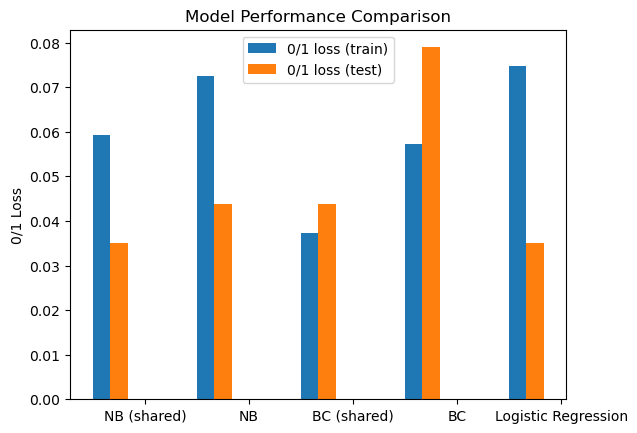

In [5]:
def plot_model_performances(models, model_names, X_train, y_train, X_test, y_test):
    # Initialize lists to store 0/1 loss (misclassification error) for training and testing data
    train_01_losses = []
    test_01_losses = []

    # Calculate 0/1 loss for each model on the training and testing data
    for model in models:
        train_01_losses.append(zero_one_loss(y_train, model.predict(X_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(X_test)))

    # Set up the x-axis positions for the bar plot
    xx = np.arange(len(models))
    bar_width = 1 / (len(models) + 1)
    group_width = len(models) * bar_width

    # Plot bars for training and test losses for each model
    plt.bar(xx - group_width / 2, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx - group_width / 2 + bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    
    # Customize the plot
    plt.xticks(xx, model_names)  # Set model names as x-axis labels
    plt.ylabel('0/1 Loss')  # Set y-axis label
    plt.title('Model Performance Comparison')  # Set plot title
    plt.legend()  # Show legend
    plt.show()  # Display the plot

# Plot the performance of each model
plot_model_performances(models, model_names, X_train, y_train, X_test, y_test)


### Comparison of the 5 Models

#### - **NB (shared):**
    - Training Accuracy: 94.07%
    - Test Accuracy: 96.49%
    - Performance: This model has a good balance between training and testing performance. The relatively low difference between training and testing accuracy indicates that the model generalizes well and is not overfitting. The test accuracy of 96.49% is the highest among all models.
    
    
#### - **NB (Naive Bayes without shared covariance):**
    - Training Accuracy: 92.75%
    - Test Accuracy: 95.61%
    - Performance: This model also shows good generalization capabilities with a training accuracy slightly lower than NB (shared). The difference between training and testing accuracy is small, indicating it is not overfitting. The performance is quite close to NB (shared), making it a strong alternative.
    
#### - **BC (shared covariance):**
    - Training Accuracy: 96.26%
    - Test Accuracy: 95.61%
    - Performance: This model has the highest training accuracy (96.26%) among all models, but its test accuracy is slightly lower than NB (shared). The small difference between training and testing accuracy shows that it generalizes well. However, it may be slightly overfitting due to the higher training accuracy compared to NB (shared).
    
    
#### - **BC (full covariance, not shared):**
    - Training Accuracy: 94.29%
    - Test Accuracy: 92.11%
    - Performance: This model shows a larger gap between training and testing accuracy compared to other Bayesian classifiers, suggesting potential overfitting. While its training accuracy is relatively high, its test accuracy is the lowest among the Bayesian classifiers.

#### - **Logistic Regression:**
    - Training Accuracy: 77.80%
    - Test Accuracy: 82.46%
    - Performance: Logistic Regression has the lowest training and test accuracy among all models. The gap between training and testing accuracy is larger, indicating underfitting. This model may not be complex enough to capture the underlying patterns in the dataset compared to the Bayesian classifiers.
    
    
#### - **Conclusion:**
    - The Naive Bayes with shared covariance (NB shared) model performs the best in terms of generalization, with the highest test accuracy (96.49%). It maintains a balance between training and test accuracy, indicating good generalization and low overfitting.
    - The BC with shared covariance (BC shared) also performs well but shows slightly more overfitting compared to NB (shared) due to its high training accuracy.
    - The Naive Bayes without shared covariance (NB) model has a test accuracy slightly lower than NB (shared), making it a good alternative with decent performance.
    - The BC without shared covariance (BC) variant shows signs of overfitting and lower test accuracy, making it less desirable compared to the shared covariance models.
    - Logistic Regression underperforms compared to all the Bayesian classifiers. It is likely underfitting the data, as indicated by its lower training and test accuracy.
    - Overall, Naive Bayes with shared covariance (NB shared) is the best model for this dataset based on its balance of training and testing accuracy, suggesting it generalizes well to unseen data.

### We Implement an experiment where we test the performance for increasing training sizes of N = 5, 10, . . . , 500.

In [ ]:
# Assume BayesianClassifier and SGDRegularisedLogisticRegressionClassifier are defined somewhere
# Initialize models for Bayesian Classifier and Logistic Regression
def initialize_models():
    return [
        BayesianClassifier(shared_cov=True, cond_ind=True),   # NB (shared)
        BayesianClassifier(shared_cov=False, cond_ind=True),  # NB
        BayesianClassifier(shared_cov=True, cond_ind=False),  # BC (shared)
        BayesianClassifier(shared_cov=False, cond_ind=False), # BC
        make_pipeline(PolynomialFeatures(1), SGDRegularisedLogisticRegressionClassifier(alpha=0.1, batch_size=100, tau_max=100000, eta=0.0005)) # Logistic Regression
    ]

model_names = ['NB (shared)', 'NB', 'BC (shared)', 'BC', 'Logistic Regression']

# Define training sizes and repetitions
training_sizes = np.arange(5, 505, 5)  # Adjusted range to include 500
n_repetitions = 10

# Store errors for each model, repetition, and training size
train_errors = np.zeros((len(training_sizes), len(model_names), n_repetitions))
test_errors = np.zeros((len(training_sizes), len(model_names), n_repetitions))

# Split full dataset first (ensures a consistent test set)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Run experiments
for i, n in enumerate(training_sizes):
    for rep in range(n_repetitions):  # Fix: Add a loop for repetitions
        
        # Randomly sample training data of size `n`
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=n, random_state=rep, shuffle=True)

        # Initialize models for each repetition
        models = initialize_models()
        
        # Fit models and record errors
        for j, model in enumerate(models):
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Record 0/1 loss (error rate)
            train_errors[i, j, rep] = zero_one_loss(y_train, y_train_pred)
            test_errors[i, j, rep] = zero_one_loss(y_test, y_test_pred)

# Calculate mean errors across repetitions
mean_train_errors = np.mean(train_errors, axis=2)
mean_test_errors = np.mean(test_errors, axis=2)

C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\ipykernel_33980\3697253222.py:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-a))
C:\Users\kumar\AppData\Local\Temp\

In [ ]:
# Print training and test errors for each training size and model
print(f"{'Training Size':<15} {'Model':<25} {'Train Error':<15} {'Test Error':<15}")
print("-" * 70)

for i, n in enumerate(training_sizes):
    for j, model_name in enumerate(model_names):
        print(f"{n:<15} {model_name:<25} {mean_train_errors[i, j]:<15.4f} {mean_test_errors[i, j]:<15.4f}")

### We create suitable plots that compare the mean train and test performances of all models as a function of training size.

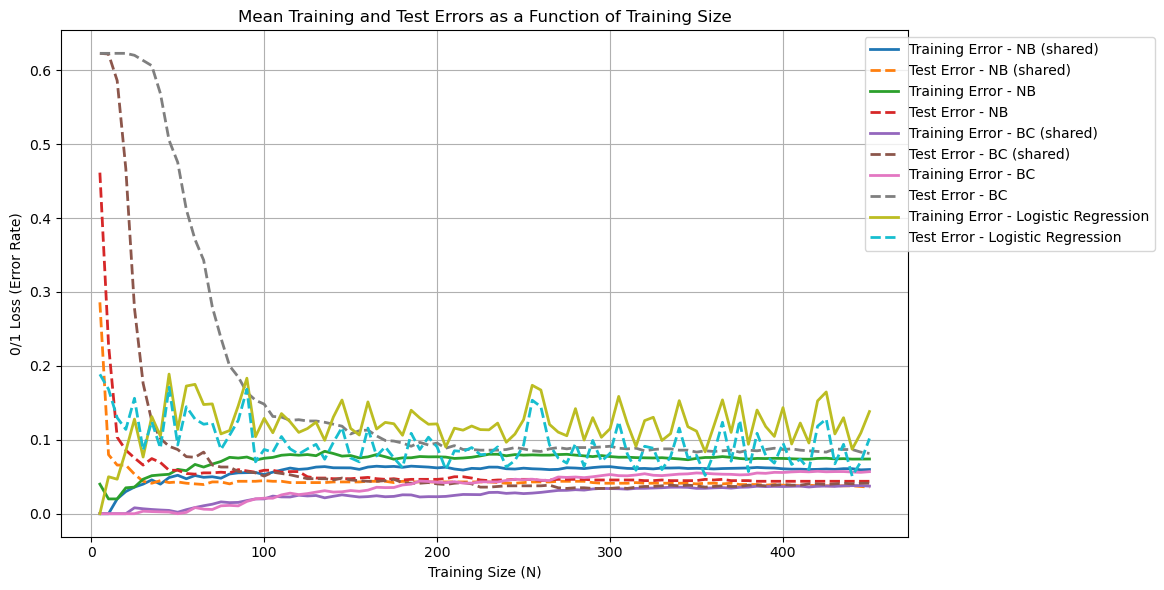

In [9]:
# Create a plot for mean train and test errors as a function of training size
plt.figure(figsize=(12, 6))

# Plotting training and test errors for each model
for j, model_name in enumerate(model_names):
    plt.plot(training_sizes, mean_train_errors[:, j], label=f'Training Error - {model_name}', linewidth=2)
    plt.plot(training_sizes, mean_test_errors[:, j], linestyle='--', label=f'Test Error - {model_name}', linewidth=2)

# Plot formatting
plt.xlabel('Training Size (N)')
plt.ylabel('0/1 Loss (Error Rate)')
plt.title('Mean Training and Test Errors as a Function of Training Size')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

#### - **Naive Bayes (NB) with shared covariance ("NB (shared)")**
    - The training error starts at 0 for small training sizes and slowly increases as more data points are added. This indicates that the model is initially perfectly fitting the small training sets but becomes slightly less accurate on larger sets due to more varied data.
    - The test error starts high and decreases as the training size increases, showing an improvement in generalization as more data is provided.
    
#### - **Naive Bayes (NB) without shared covariance ("NB")**
    - Similar to "NB (shared)", the training error starts low and increases slightly with more data. This classifier's training error stabilizes around a higher value compared to "NB (shared)".
    - The test error starts very high, suggesting overfitting when the training size is small. It reduces gradually as the training size increases, indicating better generalization with more data.

#### - **Bayesian Classifier (BC) with shared covariance ("BC (shared)")**
    - The training error starts very low (close to 0) and remains low throughout, indicating strong fitting to the training data.
    - The test error starts extremely high when training data is small and decreases with increasing training size. The reduction is more pronounced than in "NB (shared)", but the test error remains higher compared to "NB" classifiers.

#### - **Bayesian Classifier (BC) without shared covariance ("BC")**
    - Like "BC (shared)", the training error starts very low and remains low, suggesting overfitting to the training data.
    - The test error is initially very high and decreases with more data points, but it remains significantly high compared to other classifiers, suggesting persistent overfitting or poor generalization.

#### - **Logistic Regression**
    - The training error starts at 0 for very small training sizes, then increases significantly as more data is added, indicating more complexity in learning the decision boundary with more data.
    - The test error starts relatively high but decreases more steadily compared to the Bayesian classifiers, showing improved generalization as more data points are provided.

#### - **Best for Small Training Sets:** 
    Logistic Regression performs relatively better than other classifiers with small training sets. It starts with lower test error rates compared to the "NB" and "BC" variants.  For small training sets, logistic regression benefits from its linear decision boundary and regularization, which prevents it from overfitting. The "BC" classifiers show very high test errors because they overfit the small training data, unable to generalize well to unseen examples. The "NB" classifiers with shared covariance perform better but still struggle to generalize effectively with minimal data.

#### - **Best for Large Training Sets:** 
    Naive Bayes with shared covariance ("NB (shared)") performs the best when the training set is large. Its test error rate decreases and stabilizes at a low value as more training data is available, indicating robust generalization. Logistic Regression also shows good performance with larger datasets but exhibits a higher variance compared to "NB (shared)".  With more data, "NB (shared)" proves to be more stable and effective as it assumes shared covariance among the classes, which reduces model complexity and leads to better generalization. Logistic regression also improves with more data due to its robust regularization and ability to learn from more complex patterns. On the other hand, "BC" classifiers without shared covariance are likely too complex (especially for high-dimensional datasets), resulting in poor generalization even with larger datasets.

#### - **Effect of Model Complexity**
    The "BC" classifiers, especially without shared covariance, are highly flexible and have many parameters, which makes them prone to overfitting when training data is limited. "NB" models, by assuming conditional independence or shared covariance, simplify the model, leading to better generalization performance as the training size increases. Logistic regression, being a discriminative model, is effective with a balance between bias and variance, especially with regularization.